# Human Resources Data Analysis

The aim of this notebook is to showcase exploratory data analysis techniques, using data from the Human Resources department of an company, and to train a model which can predict a target variable. 

The data is retrieved from https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists.

It has 14 variable columns and over 19000 observations (rows of data). The data is in regards to Data Science employees at a company, who have different levels of education and experience. The aim is to predict which employees are looking to change jobs. This is a very important question for any HR team, as the cost in money and hours to replace employees can be significant. Therefore, we want to see if we can reliably predict which employees might stay, versus which might leave. 

First we will analyse the variables and draw some plots, to get an understanding of the data. Then we will check the assumptions needed for our statistical tests. We will use a simple Logistic Regression to predict the target variable - whether we think an employee will leave soon or not. When we are happy with our accuracy, we can try to use some more sophisticated techniques. 

### A Note on Style

Code will be annotated to explain its purpose. Longer text will be interleaved, to explain techniques or findings.  

In [1]:
# load packages
import pandas as pd # for manipulating data
import numpy as np  # for mathematical operations
import matplotlib.pyplot as plt # for plots
import seaborn as sns # also for plots
import researchpy as rpy # for crosstab tables and statistical testing

df = pd.read_csv('aug_train.csv')
df_reset = df # this is always a good idea - if you make a mistake, you can reset the dataset quickly without reloading it.
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


Here we see the data. We observe the following:

* enrollee_id, city_development_index & training_hours are numerical variables. enrollee_id is likely individual for each person.
* city, gender, relevent_experience [sic], enrolled_university, education_level, major_discipline & company_type are all categorical variables.
* experience & last_new_job also seem to be categorical, with ordinal numerical variables (i.e. 1, 5, 10, etc.)
* target is our variable to predict.
* there seem to be NA values (read as NaN in pandas) - i.e. missing values.

We should check how many missing values we have - this is very important to know. Sometimes we can fill them in, other times we have to ignore them or delete them. 

In [3]:
df.isna().sum().sort_values() # find NaN values in each column, add them up, put them in order

enrollee_id                  0
city                         0
city_development_index       0
relevent_experience          0
training_hours               0
target                       0
experience                  65
enrolled_university        386
last_new_job               423
education_level            460
major_discipline          2813
gender                    4508
company_size              5938
company_type              6140
dtype: int64

So we have a lot of missing information for company_type and company_size. We also have a lot of missing values for gender, and quite a few for major_discipline. The rest remaining variables have relatively few missing values. 

Now we will print the kinds of values that we have in each categorical column (not numerical).

In [8]:
df_categorical = df.drop(['enrollee_id','city_development_index','training_hours'],axis=1) # remove numerical variables

In [9]:
# write a loop to print out column name, different values in column and how many, and space
for col in df_categorical.columns:
    print(col)
    print(df_categorical[col].value_counts())
    print('\n')

city
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64


gender
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64


relevent_experience
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64


enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64


education_level
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64


major_discipline
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64


experience
>20    3286
5      1430
4

We can make some observations:

* we have 123 different cities. We have a lot of people from some cities, but from other cities only a few people. NOTE - this has nothing to do with city population. We don't know what these cities are. We just know that, for some reason, we have more people from some cities and less from others. This could indicate the size of each cities population, but we can't be sure of that. 
* for gender, we have a very large amount of males. Remember from above that there are a lot of missing values for gender. It is possible that 'female' caused an error, and so we are missing those values. It is also possible that there are many more males than females in this dataset. We can't tell yet - we would have to contact the data provider about this. 
* almost three times as many people have relevant experience as those who have no relevant experience.
* most people are not enrolled in a university course at the moment. Of those enrolled, more are full-time than part-time.
* most people are graduates (i.e. have a Bachelor's). Many have a Master's. There are very few with PhD's, and quite a few only have high school education. This is interesting, but might reflect a known pattern in the Tech industry where degrees are not absolutely necessary. 
* STEM (Science, Technology, Engineering & Mathematics) makes up the vast majority of graduates. Only 223 people have no major (i.e. no degree). We notice that this is much fewer than those with a high school or primary education seen above. But in this variable we have 2813 missing values (seen above). This probably explains the low level of recorded people with no major. 
* experience is recorded individually per year. We can possibly put these into groups - we know that most jobs put employees into, for example, 0-2 years, 3-5 years, 5-10 years, etc. This might help with analysis.
* most companies which we have in our dataset have less than 500 employees, but we also have many with over 5000. There is an interesting dip between 500-999 and 5000-9999. Remember, we have many missing values for this variable. 
* The vast majority of companies seem to be Private Limited (Pvt Ltd) companies. However, we also have a large amount of missing values for this variable. So we can't conclude to much - perhaps the missing 6140 values are not Private Limited. 
* last_new_job - this is the number of years since changing to current job. Interestingly, most people changed job just 1 year ago. After this, most people changed 2 years ago, or it's their first job ('never'), or they have been in their job over four years. There is a dip at year 3 and year 4. This reflects some things we know about the Data Science industry - it is relatively new, so many people are just beginning their careers. These young career professionals are changing job relatively quickly, staying just one or two years, before changing. And there is also a small group of people who have stayed in their jobs for a long time - we don't know if >4 years means 5, 8, 10 or 20. 

Now we can look at the numerical variables - enrollee_id, city_development_index, and training_hours. Here are the things we want to know:

* are the enrollee_id numbers really unique?
* what are the minimum, maximum, and average city_development_index and training_hours values?

In [12]:
# using duplicated() to find any duplicated values. TRUE if duplicated, FALSE otherwise. 
# TRUE is the same as 1, and FALSE is the same as 0. So we sum to find how many are duplicated.
# we get 0, meaning that each enrollee_id is indeed unique. 
df.enrollee_id.duplicated().sum()

0

In [14]:
df.city_development_index.describe()
# summary statistics for city_development_index
# we know from the data source that this data is standardised - i.e. between 0 and 1. 
# lowest is 0.44, highest is 0.94, and the mean is 0.82. This tells us that most cities have a high development index. 

count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

In [15]:
df.training_hours.describe()
# this variable corresponds to the number of hours completed by each candidate for training courses provided by the company. 
# The minimum trianing hours is one hour, the maximum is 336 hours. 
# the mean is 65, with a standard deviation of 60. This indicates a large spread of hours, from very few to a lot. 

count    19158.000000
mean        65.366896
std         60.058462
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

We can illustrate city_development_index and training_hours visually with a histogram, to get a better idea of the spread.

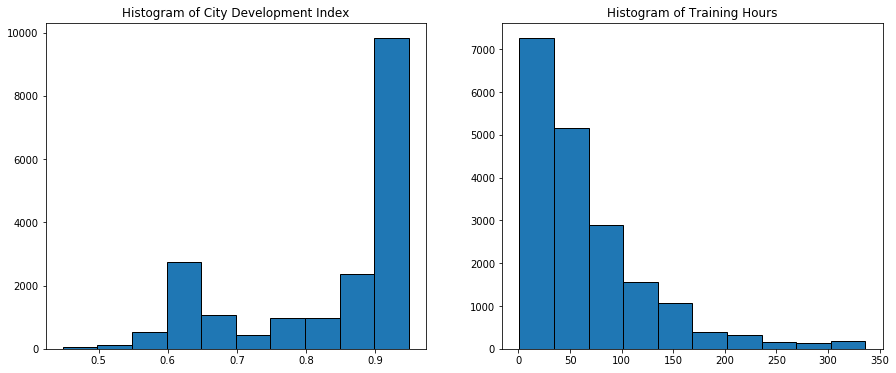

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

ax1.hist(df.city_development_index,edgecolor='black')
ax1.set_title('Histogram of City Development Index')

ax2.hist(df.training_hours,edgecolor='black')
ax2.set_title('Histogram of Training Hours');

We see here the distributions of city_development_index and training_hours. We see that most cities have a high development index - this is understandable, as we are dealing with cities in the US. However, there are also quite a few cities with development around 0.6.

As for training_hours, we see that most people have done between 0 and 100 hours. This also makes sense. There are a few people who have done hundreds of hours of training - this may or may not be useful data. We would need more information from the data provider. 

Now we can do similar visualisations of the other, categorical variables. Visualisation is a very useful way to get an innate sense of the data - much more than by just looking at numbers. We do this with our target variable in mind - maybe we can see some patterns among those people who want to find a new job.

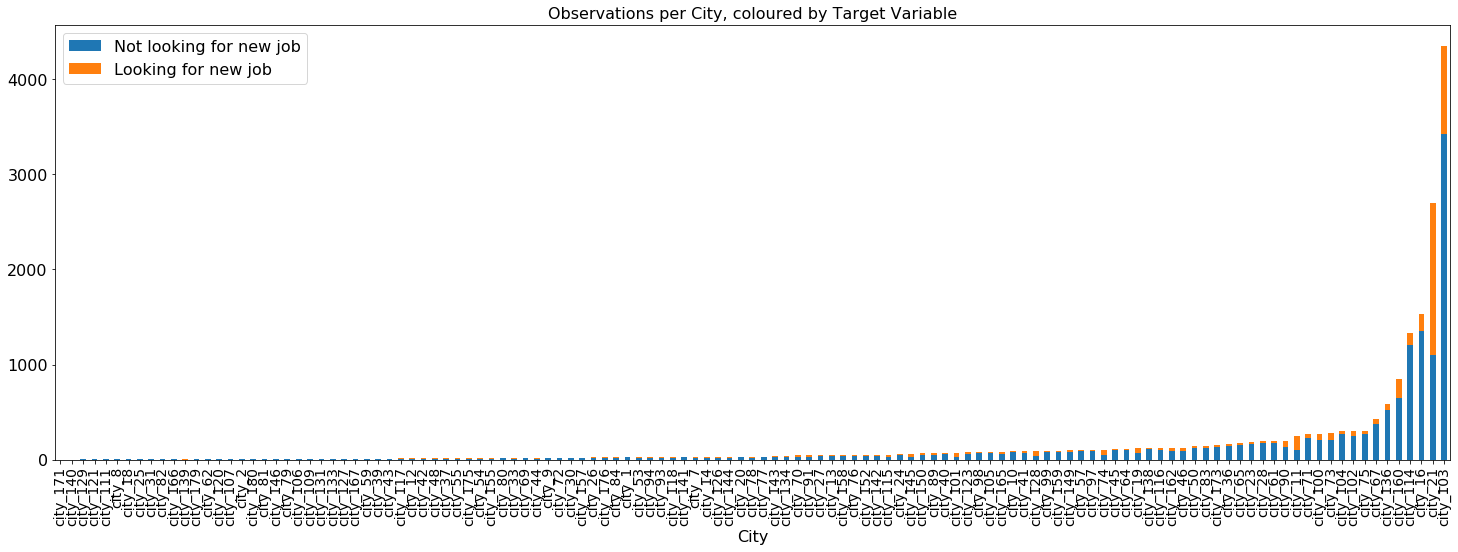

In [3]:
plt.rc('xtick',labelsize=14) # set ticks text size
plt.rc('ytick',labelsize=16)

# combine city and target variables 
cities_by_target = pd.crosstab(df.city, df.target)
# plot, in increasing order
cities_by_target.loc[cities_by_target.sum(axis=1).sort_values().index].plot.bar(stacked=True,figsize=(25,8))
# set title and x-axis label
plt.title('Observations per City, coloured by Target Variable',fontsize=16)
plt.xlabel('City',fontsize=16)
# change labels for legend
my_labels = ['Not looking for new job','Looking for new job']
# change legend size and position
plt.legend(loc=2,labels=my_labels,prop={'size': 16});

Above we have plotted the cities and used colours to show the proportion of people in those cities who want to change job versus those who don't want to change. In the two cities which we have the most people for, there are many who want to change job. This might reflect a better job market for Data Science, i.e. a large city.

Because we have mostly small sample sizes from most cities, it might be difficult to incorporate every city successfully into predictions. However, we could restrict ourselves to the top four or five cities, and use these as yes/no variables - i.e. if a person is from one of these cities, that might help predict the target variable, but if the person is not from one of these cities, then we ignore the city they are from. 

Although we can't make too much inference on the target variable depending on the city, we might be able to make some inference on city_development_index. Below we do the same as above - crosstabulate the variable city_development_index with the target variable. Then we get the total per each city, and restrict ourselves to only those cities where we have 60 or more observations (this is an arbitrary number but should give us some certainty that the values we see in the sample reflect the population). We can then plot, as above. 

In [105]:
# crosstabulate city_development_index with target
development_by_target = pd.crosstab(df.city_development_index, df.target)
# get Total column by adding up
development_by_target['Total'] = development_by_target.sum(axis=1)
# select only those cities with more than 60 observations
development_over60 = development_by_target.loc[development_by_target.Total > 60]



In [122]:
# convert to percentage to see proportions of people looking for new job
development_over60['Percentage Not Looking'] = development_over60.iloc[:,0] / development_over60.iloc[:,2]
development_over60['Percentage Looking'] = development_over60.iloc[:,1] / development_over60.iloc[:,2]
development_over60.head(15)

target,0.0,1.0,Total,Percentage Not Looking,Percentage Looking
city_development_index,,,,,
0.527,0.434783,52,92,0.434783,0.565217
0.550,0.404858,147,247,0.404858,0.595142
0.555,0.412698,37,63,0.412698,0.587302
0.558,0.426667,43,75,0.426667,0.573333
0.579,0.481481,70,135,0.481481,0.518519
0.624,0.408956,1597,2702,0.408956,0.591044
0.666,0.859649,16,114,0.859649,0.140351
0.682,0.621849,45,119,0.621849,0.378151
0.689,0.764706,24,102,0.764706,0.235294


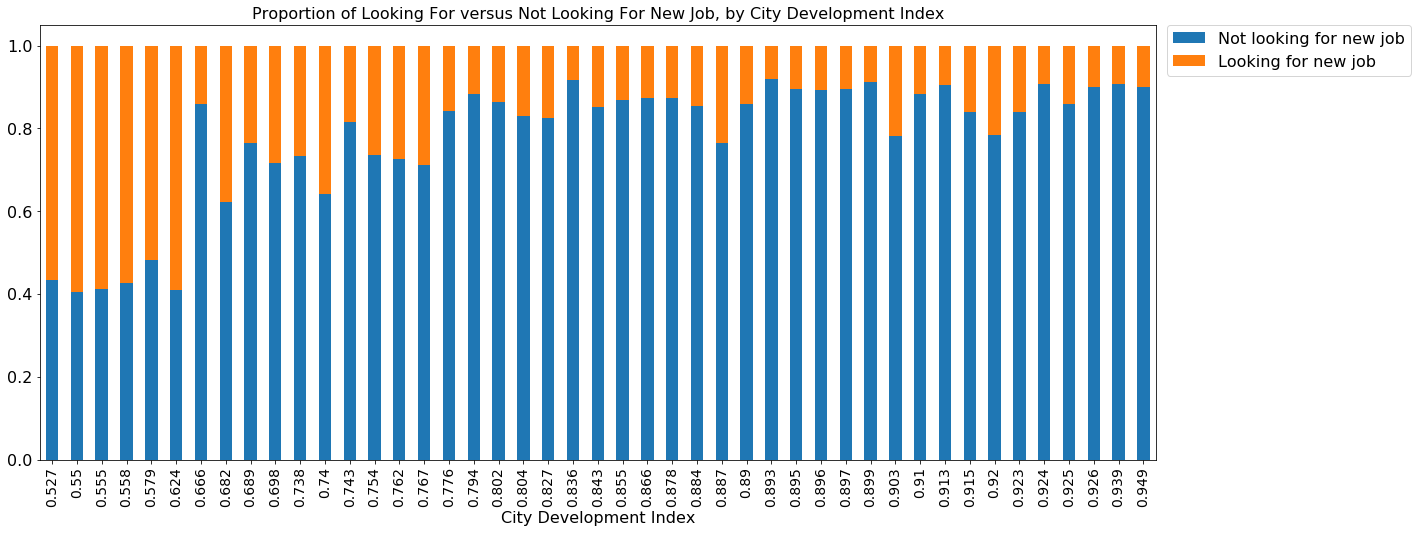

In [137]:
# need to round city development scores to 3 decimal places
development_over60.index = development_over60.index.map(lambda x:np.round(x,3))
# now plot proportions of people looking for jobs, versus not looking for jobs, based on city development index
development_over60.iloc[:,3:5].plot.bar(stacked=True,figsize=(20,8))
plt.title('Proportion of Looking For versus Not Looking For New Job, by City Development Index', fontsize=16)
plt.legend(labels = my_labels,prop={'size': 16}, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.);
plt.xlabel('City Development Index',fontsize=16);

Here we see an interesting trend. The cities with a lower development index have a higher proportion of people looking for a new job, and this proportion generally decreases as the city development index increases. This probably tells us that those people living in the less developed cities are looking for jobs elsewhere, in order to move to a more developed city. Interestingly, those cities which are very highly developed have a very low proportion of people looking to move. 

This is important for a company to know - although the rents for premises in less developed cities might be much cheaper, the turnover of highly educated or highly skilled professionals might end up costing the company more in hiring costs over the long term.


Now we will look at relevant experience and university enrollment, and how these reflect people looking to change job. We have 386 NaN values in enrolled_university, out of a total of over 19000, so we can drop these. Dropping a small proportion of the dataset for visualisation purposes is generally not going to give us many interpretation problems. 

In [4]:
experience_by_target = pd.crosstab(df.relevent_experience, df.target)
experience_by_target

target,0.0,1.0
relevent_experience,,
Has relevent experience,10831,2961
No relevent experience,3550,1816


In [169]:
# now convert to percentage by dividing across by row sums
experience_by_target.loc['Has relevent experience'] = experience_by_target.loc['Has relevent experience']/(10831+2961)
experience_by_target.loc['No relevent experience'] = experience_by_target.loc['No relevent experience']/(3550+1816)
experience_by_target

target,0.0,1.0
relevent_experience,,
Has relevent experience,0.785310,0.214690
No relevent experience,0.661573,0.338427


In [5]:
# drop NaN values for enrolled university, crosstabulate with target variable
enrollment_by_target = pd.crosstab(df.enrolled_university.dropna(),df.target)
enrollment_by_target

target,0.0,1.0
enrolled_university,,
Full time course,2326,1431
Part time course,896,302
no_enrollment,10896,2921


In [174]:
# convert to percentage, as above
enrollment_by_target.loc['Full time course'] = enrollment_by_target.loc['Full time course']/(2326+1431)
enrollment_by_target.loc['Part time course'] = enrollment_by_target.loc['Part time course']/(896+302)
enrollment_by_target.loc['no_enrollment'] = enrollment_by_target.loc['no_enrollment']/(10896+2921)
enrollment_by_target

target,0.0,1.0
enrolled_university,,
Full time course,0.619111,0.380889
Part time course,0.747913,0.252087
no_enrollment,0.788594,0.211406


NOTE - although we have different values for each category in both of these variables, because we have so many entries (more than 1000 in each), it is okay here to convert everything to a percentage in order to see proportions. In other cases, this might give us a wrong impression, but here it is alright for exploratory purposes.

In [178]:
experience_by_target.values

array([[0.78531032, 0.21468968],
       [0.66157287, 0.33842713]])

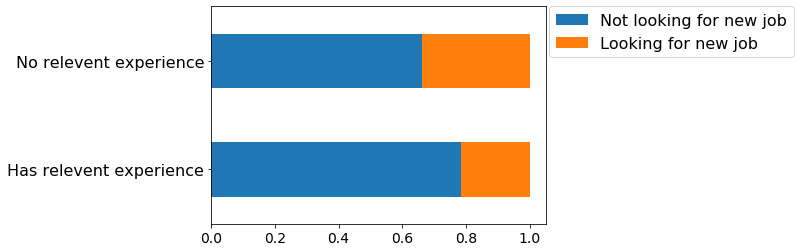

In [208]:
experience_by_target.plot.barh(stacked=True)
plt.legend(labels = my_labels,prop={'size': 16}, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('');

We see that more people with no relevant experience are looking for a job than those with relevant experience. This might tell us something about early Data Science professionals looking to change jobs a few times at the start of their career, in order to build experience, and increase salary. 

This might tell us that, as a company, we should hire those with some level of relevant experience, in order to avoid replacement costs. However, this saving might be offset by the higher salary which an employee with relevant experience can command. 

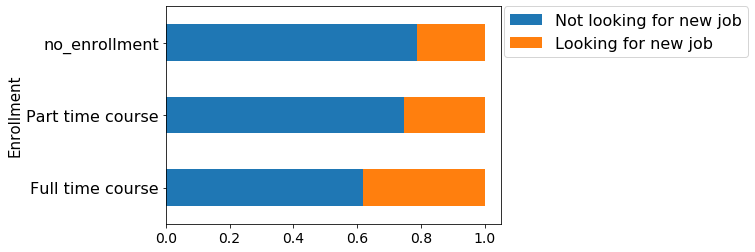

In [216]:
enrollment_by_target.plot.barh(stacked=True)
plt.legend(labels = my_labels,prop={'size': 16}, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Enrollment',fontsize=15);

Here we see that those enrolled in full-time courses are more likely to be looking to change job than those in part-time or no course. This might be a factor in our company hiring - we might look for people who are not enrolled in full-time courses. However, we should note here that those enrolled in full-time courses might be taking internships during their holidays, and this might be the reason why they are looking to change job, as internships are often limited to only a few weeks. 


Now we will look at education level and major discipline with regard to people looking to change jobs. We will see that we have relatively few people with Primary School and PhD levels of education. Therefore, we might be more interested in those with Graduate and Masters levels of education. Those with a High School level of education will also be an interesting group to look at - as we have a good amount of observations, but they are outnumbered by graduates and postgraduates.

In [6]:
# get education level crosstabulated with percentage
education_by_target = pd.crosstab(df.education_level.dropna(), df.target)
education_by_target

target,0.0,1.0
education_level,,
Graduate,8353,3245
High School,1623,394
Masters,3426,935
Phd,356,58
Primary School,267,41


In [221]:
# convert to percentage, as above
education_by_target.loc['Graduate'] = education_by_target.loc['Graduate']/(8353+3245)
education_by_target.loc['High School'] = education_by_target.loc['High School']/(1623+394)
education_by_target.loc['Masters'] = education_by_target.loc['Masters']/(3426+935)
education_by_target.loc['Phd'] = education_by_target.loc['Phd']/(356+58)
education_by_target.loc['Primary School'] = education_by_target.loc['Primary School']/(267+41)


target,0.0,1.0
education_level,,
Graduate,0.720210,0.279790
High School,0.804660,0.195340
Masters,0.785600,0.214400
Phd,0.859903,0.140097
Primary School,0.866883,0.133117


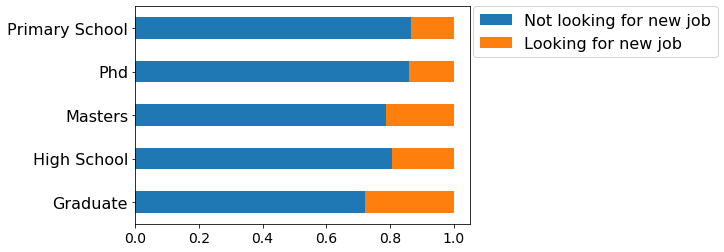

In [223]:
education_by_target.plot.barh(stacked=True)
plt.legend(labels = my_labels,prop={'size': 16}, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('');

We might make some inferences here - more people with Bachelor's and Master's degrees are looking for new jobs than those with lower education or those with PhD's. However, we have two things to be careful of here. Firstly, we have many more people with Bachelor's and Master's than with other levels of education. Secondly, this doesn't tell us about specific job types, salaries, responsibilities, etc. 

We might infer that those with PhD's have already found niche positions, and will be more specific about what jobs they move to. Similarly, people with a primary or secondary level of education might be careful about moving job, seeing as there are so many graduates and postgraduates which they need to compete with. We might also infer that there will be a larger age span among graduates and postgraduates (i.e. those having just left university), whereas people with PhD's are likely somewhat older, and more settled in their careers. However, these are all just ideas, and without more data, we cannot be certain about any of this.  

Looking at the number of Major Disciplines, we see that 75% of the recorded majors are STEM. Note - these only apply to people with a college education. By looking at the crosstabulation table, we see that generally the percentages are similar across disciplines. Arts and Humanities have a slightly smaller proportion of people looking to change jobs. However, we must be careful in assuming too much - we don't have a lot of observations for any discipline except STEM. 

Those with STEM or Business majors have a higher proportion of people looking to change job, but this is also true of those with no major, or with Other. Therefore, we might conclude that Major Discipline might not give us too much insight into whether a person might be looking to change jobs. We might also conclude that experience likely plays a role - a Humanities major with 5 years' relevant experience in Data Science might have better job prospects than a STEM major with no relevant experience yet. 

In [231]:
df.major_discipline.value_counts()

STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [7]:
major_by_target = pd.crosstab(df.major_discipline, df.target)
major_by_target['Total'] = major_by_target.sum(axis=1)
major_by_target['Percentage Not Looking'] = major_by_target.iloc[:,0] / major_by_target.iloc[:,2]
major_by_target['Percentage Looking'] = major_by_target.iloc[:,1] / major_by_target.iloc[:,2]
major_by_target

target,0.0,1.0,Total,Percentage Not Looking,Percentage Looking
major_discipline,,,,,
Arts,200,53,253,0.790514,0.209486
Business Degree,241,86,327,0.737003,0.262997
Humanities,528,141,669,0.789238,0.210762
No Major,168,55,223,0.753363,0.246637
Other,279,102,381,0.732283,0.267717
STEM,10701,3791,14492,0.738407,0.261593


Looking at the experience variable, we see that we have values from <1 year to >20 years. We will order these, and check the distribution of years of experience.

In [285]:
# set index to put years in order (setting as string object, as we have '<' and '>' characters)
# if we didn't have these characters, we could just sort as numbers
ind = pd.Index(['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20'])

# get the counts for each number of years experience
years_experience = df.experience.value_counts()
years_experience = years_experience.loc[ind]
years_experience

<1      522
1       549
2      1127
3      1354
4      1403
5      1430
6      1216
7      1028
8       802
9       980
10      985
11      664
12      494
13      399
14      586
15      686
16      508
17      342
18      280
19      304
20      148
>20    3286
Name: experience, dtype: int64

We see here that, unlike the variables which we had before, most of these years seem fairly evenly distributed, except for >20 years. We can also check this visually below with a bar plot. 

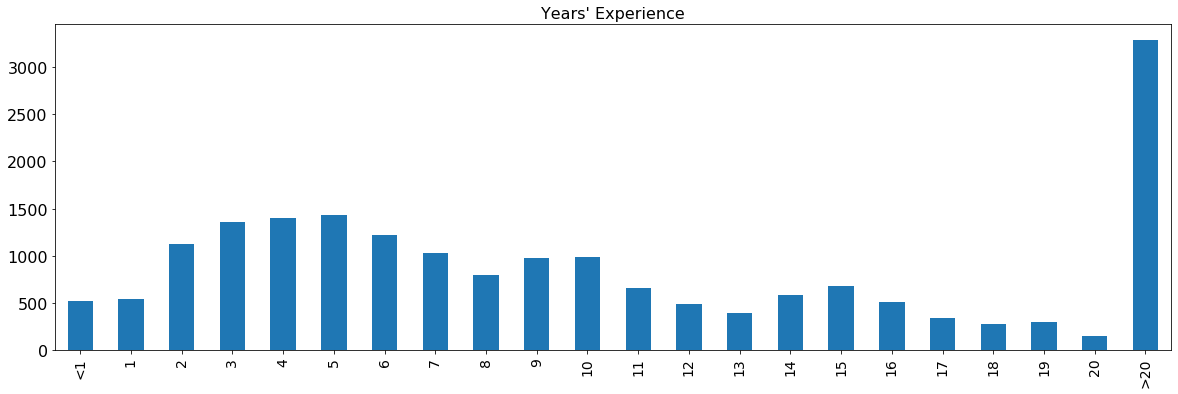

In [289]:
years_experience.plot(kind='bar',figsize=(20,6))
plt.title("Years' Experience",fontsize=16);

We have a good distribution of years' experience here. >20 is a bit of an outlier, so we might focus more on the mid-range of values. Below we crosstabulate and plot to see the proportions of people looking for a new job, versus not looking for a new job, by years' experience. 

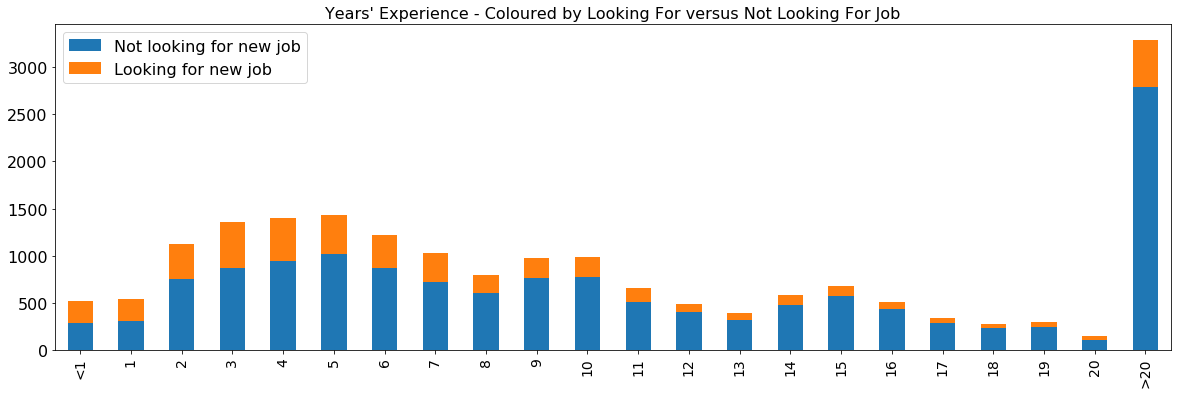

In [299]:
# crosstabulate experience with target variable
experience_by_target = pd.crosstab(df.experience,df.target)
# sort, as above
experience_by_target = experience_by_target.loc[ind]

# plot as stacked bar plot
experience_by_target.plot.bar(stacked=True,figsize=(20,6))
# set legend
plt.legend(labels=my_labels,fontsize=16)
# set title
plt.title("Years' Experience - Coloured by Looking For versus Not Looking For Job",fontsize=16);

We see that, for the most part, those people with less years of experience have a higher proportion of people looking for a new job. This seems to decrease from about 11 years of experience upwards, until we get to those people with over 20 years of experience. 

As we stated before, >20 years is a bit of an outlier, both in terms of how many observations we have, and also in its proportion of people looking for a new job. We might infer that those with this amount of experience might be working on a contract consultancy basis, and this might be a factor in why there is a large proportion of them looking for a new job.

In our company, when we are hiring, of course different jobs will have different levels of experience requirements (e.g. 0-2, 3-5, 5+, etc.) Therefore, in practice, we don't need to worry so much about this variable, unless we have a candidate with much more experience than the job requires - this candidate might be better suited to a more complex role, with a comparatively higher level of responsibility and salary. 

Looking at last_new_job, the variable which measures the years since a person last changed jobs, we get the following counts.

never    2452
1        8040
2        2900
3        1024
4        1029
>4       3290
Name: last_new_job, dtype: int64


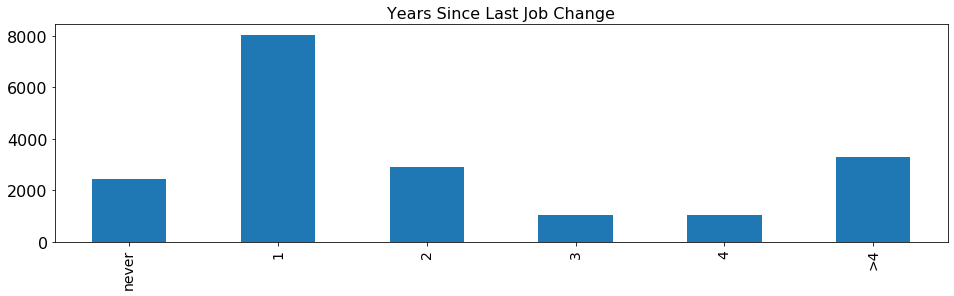

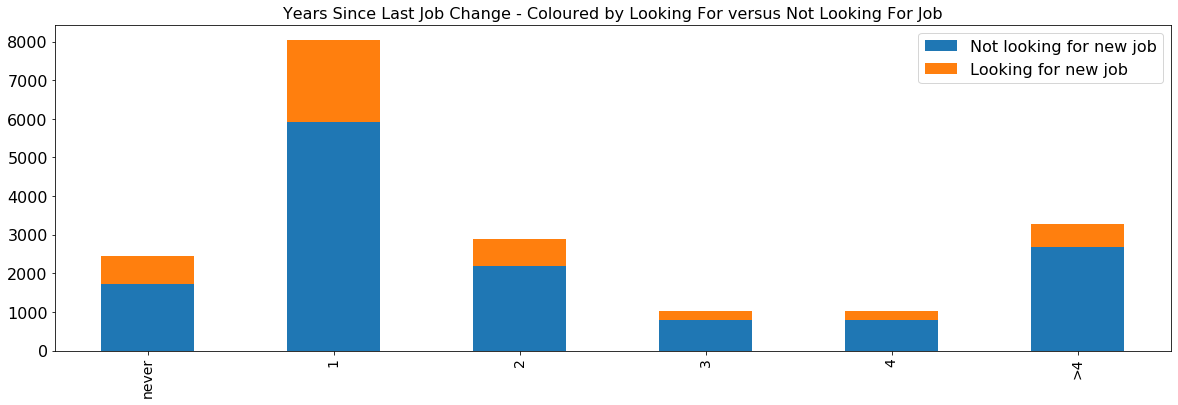

In [309]:
# set index, for better readibility
ind2 = pd.Index(['never','1','2','3','4','>4'])
years_since_job_change = df.last_new_job.value_counts()
# put index in order
years_since_job_change = years_since_job_change.loc[ind2]
# print out table of values
print(years_since_job_change)

# plot distribution
years_since_job_change.plot.bar(figsize=(16,4))
plt.title('Years Since Last Job Change',fontsize=16);

# crosstabulate experience with target variable
job_change_by_target = pd.crosstab(df.last_new_job,df.target)
# sort, as above
job_change_by_target = job_change_by_target.loc[ind2]

# plot as stacked bar plot
job_change_by_target.plot.bar(stacked=True,figsize=(20,6))
# set legend
plt.legend(labels=my_labels,fontsize=16)
# set title
plt.title("Years Since Last Job Change - Coloured by Looking For versus Not Looking For Job",fontsize=16);

We see that most people have changed job within the last year, and this value decreases for 3 and 4 years, but increases again after 4. This is likely because all years after 4 will be included in the same category.

We can see that those with 1 year of experience also have a much higher proportion of people looking for a new job. This reflects what we inferred earlier - people at the start of their Data Science careers, looking to gain experience and increase salary by changing jobs. 

The variables gender, company_size and company_type have a lot of missing data. Gender is likely so skewed as to be useless, and we might assume that a person's gender will not affect their desire to change jobs. We can see the crosstabulated table below. The proportions are relatively similar. We can likely discard this variable, due to its imbalance and lack of predictive power. 

In [310]:
pd.crosstab(df.gender, df.target)

target,0.0,1.0
gender,,
Female,912,326
Male,10209,3012
Other,141,50


Company_size and company_type are also missing a lot of data, but we should look at the proportions anyway, in case there are any patterns. 

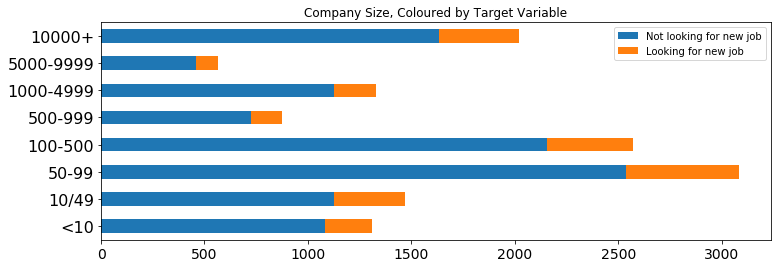

In [325]:
ind3 = pd.Index(['<10','10/49','50-99','100-500','500-999','1000-4999','5000-9999','10000+'])
pd.crosstab(df.company_size, df.target).loc[ind3].plot.barh(stacked=True,figsize=(12,4))
plt.title('Company Size, Coloured by Target Variable')
plt.legend(labels = my_labels);

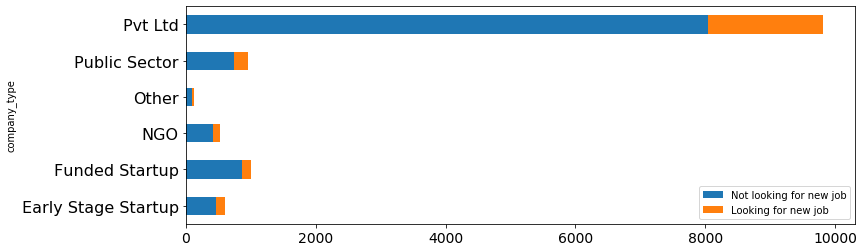

In [324]:
pd.crosstab(df.company_type, df.target).plot.barh(stacked=True,figsize=(12,4))
plt.legend(labels=my_labels);

It seems that there is a larger proportion of people looking for a new job in companies of between 50 and 500 employees, with a similar proportion reflected in those companies over 10000 people. The relatively small proportion in companies of between 500 and 9999 people might be random chance, or due to missing values (i.e. a data entry error or some sort of error with the data file). 

As we are aiming to predict retention for our company, and since we would know how many employees we have, we could perhaps use this data on an ad-hoc basis, but we shouldn't be certain of its predictive power just yet.

As for company_type, we have the same issue of missing data. We might assume that those people working for NGOs (Non-Governmental Organisations) or Startups might also have reasons for not wanting to change job, or indeed, to admit to it. Therefore, with all these things in mind, we should be careful of making any assumptions or drawing any inferences on this variable alone. 

Our final potential predictor variable is training_hours. We will look at its distribution, and its proportions for people looking for a new job. It is a numerical variable, and so has a lot of values. We could put these into categories, but it is not necessary at this point, and might be better left as a numerical variable for our predictive model.

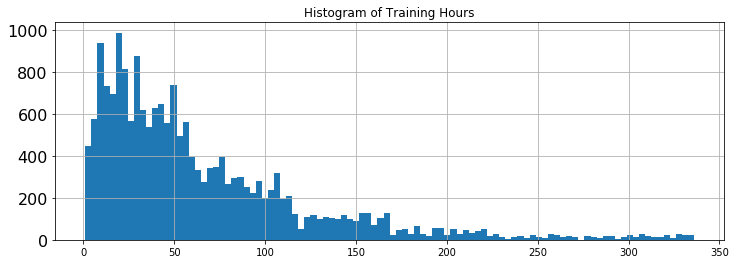

In [362]:
df.training_hours.hist(bins=100,figsize=(12,4))
plt.title('Histogram of Training Hours');

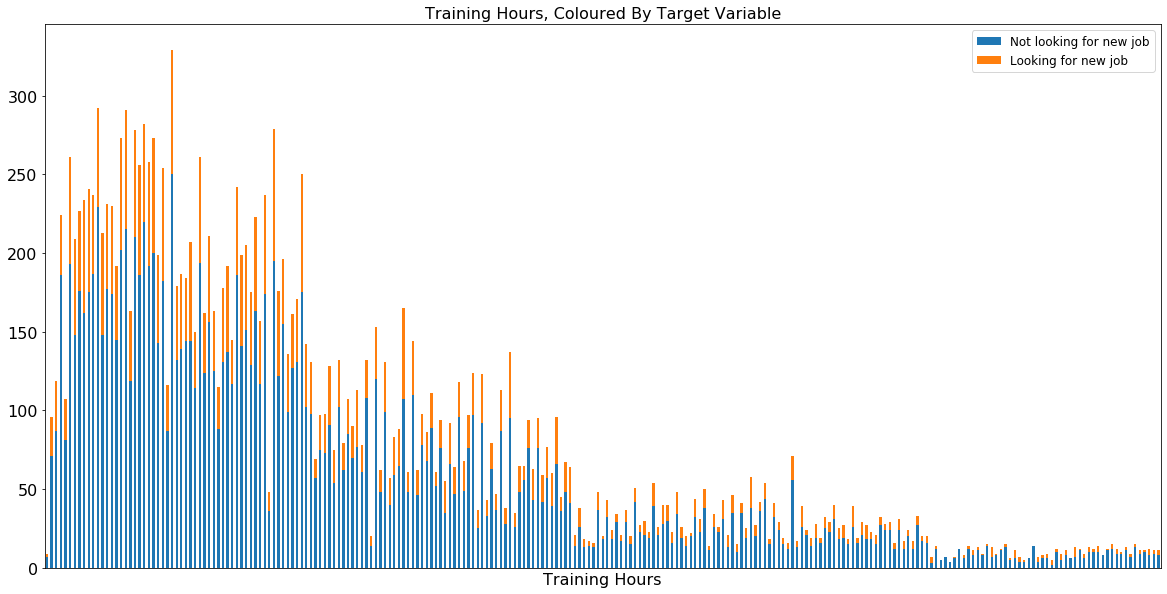

In [366]:
plt.rc('xtick',labelsize=10)
pd.crosstab(df.training_hours, df.target).plot.bar(stacked=True,figsize=(20,10))
plt.title('Training Hours, Coloured By Target Variable',fontsize=16)
plt.xlabel('Training Hours',fontsize=16)
plt.xticks([])
plt.legend(labels=my_labels,fontsize=12);

We can see that the proportion of people looking for a new job decreases as training_hours increases. As this is a numerical variable with a large range of observed values, it could be useful to include in our predictive model.

Finally, a word on our response variable, df.target. We see the value counts for that variable below. This corresponds to about 75% of people in our dataset not looking for a job, and about 25% of people looking for a job. 

In [368]:
df.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

### Correlations and Scatterplots

Now that we have done Exploratory Data Analysis on each of the variables individually and have a better understanding of each variable as well as the dataset as a whole, we can do some analysis on how these variables interact with each other. 

As experience is a categorical which is really numbers, we can convert this to numbers by replacing any '<' or '>' characters with numbers. We will use colours to illustrate the our target variable. 

First we will plot experience against city_development index, with our target variable by colour. We will change '<1' to 0, and '>20' to 21. Then we can convert this variable to a numeric type. This will return some warnings, but because we know that, we can suppress them and just check our data in practice to make sure that everything has worked correctly. 

In [108]:
import warnings 
warnings.filterwarnings('ignore')

In [109]:
# set any '<1' values to '0'
df.experience.loc[df.experience == '<1'] = '0'
# set any '>20' values to '21'
df.experience.loc[df.experience == '>20'] = '21'
# check data
df.experience

0        21
1        15
2         5
3         0
4        21
         ..
19153    14
19154    14
19155    21
19156     0
19157     2
Name: experience, Length: 19158, dtype: object

In [137]:
# convert experience to numbers, making sure to drop NaN values, as these can't be converted
df.experience = df.experience.dropna().astype(dtype='int32')

We are aiming to create plots where we can see some correlation pattern in the interaction of variables, and how our target variable changes depending on these. However, our two plots below are not so illustrative. In the first plot, we can see that there are more people looking for a new job (magenta dots) in cities with a lower development index (bottom left corner), especially with less years of experience. Moving towards the right, we see many more people who are not looking for a new job (black dots), as their experience increases, and especially as city_development_index increases.

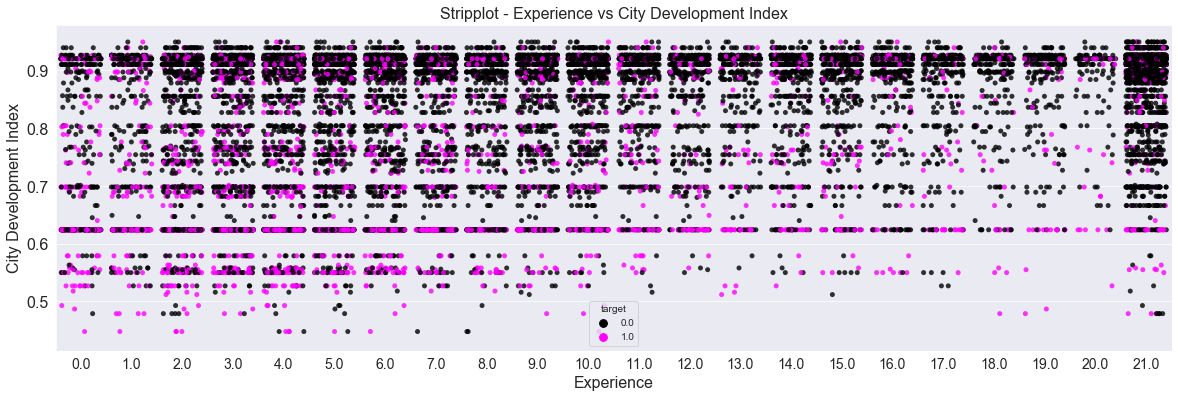

In [742]:
# plot experience against city_development index, colour by target variable

plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
sns.stripplot('experience','city_development_index',data=df,jitter=0.4,hue='target',palette=['black','magenta'],alpha=0.8)
plt.xlabel('Experience',fontsize=16)
plt.ylabel('City Development Index',fontsize=16)
plt.title('Stripplot - Experience vs City Development Index',fontsize=16);

Below we have a similar plot of training_hours against last_new_job. This plot gives us some insight, but like with the plot above, there are so many data points that it is difficult to gain any real insight into correlation. 

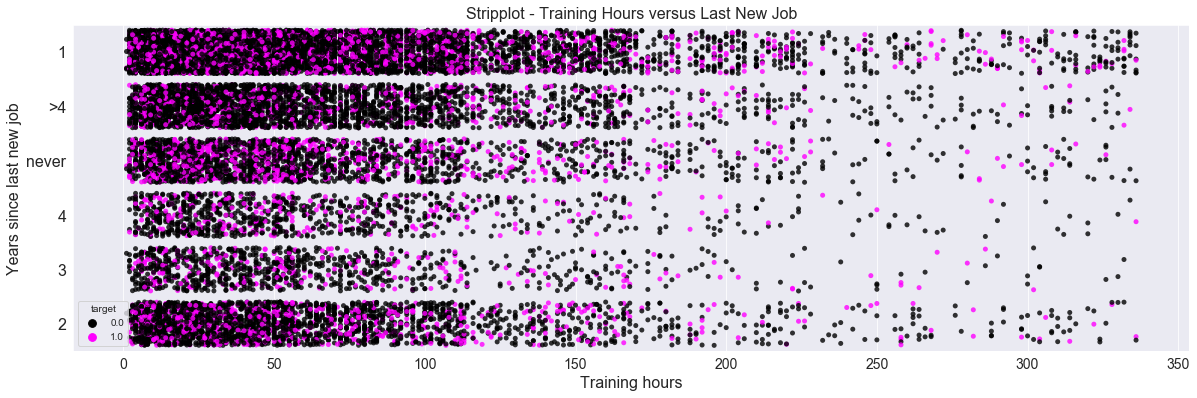

In [741]:
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
sns.stripplot('training_hours','last_new_job',data=df,jitter=0.4,hue='target',palette=['black','magenta'],alpha=0.8)
plt.xlabel('Training hours',fontsize=16)
plt.ylabel('Years since last new job', fontsize= 16)
plt.title('Stripplot - Training Hours versus Last New Job',fontsize=16);

These correlation-style scatterplots are not giving us much more insight. Instead, we can use some statistical tests to check the correlation and interaction between variables. 

### Statistical Tests 

When checking interactions between variables, we have a few things to consider. We want to know:

* what predictor variables have a strong relationship with our target variable?
* what predictor variables have a strong relationship with each other?
* how can we quantify this relationship numerically?

In general, we want to find predictor variables which have a strong relationship with our target variable, as this is useful for predicting our target variable. We also want to find predictor variables which have a strong relationship with each other, because this can affect any model we use later in a negative way. 

### Correlation vs Relationship

The correlation between two numerical variables (experience, city_development_index) can be tested using the Pearson R test from SciPy. 

The correlation between one numerical and one categorical variable (experience, target) can also be tested using Pearson R, as our target is binary with 0 and 1. This is sometimes known as Point Biserial R.

The relationship between two categorical variables (education_level, enrolled_university) cannot be tested with Pearson R, but we can use Cramer's V to test the strength of the relationship. NOTE - this is NOT the same as correlation.

Our correlation tests with take values of between -1 and 1, whereas our Cramer's V tests will take values of between 0 and 1. 

For correlation, we have the following (generalised) interpretations:

* -1 is perfect negative correlation, 1 is perfect positive correlation (only happens when variables are identical)
* 0 is no correlation
* Between -0.3 and 0, or 0 and 0.3, is weak correlation (negative or positive) 
* Between -0.6 and -0.3, or 0.3 and 0.6, is moderate correlation (negative or positive) 
* Between -0.8 and -0.6, or 0.6 and 0.8, is strong correlation (negative or positive) 
* Below -0.8 or above 0.8 is very strong correlation (negative or positive)

For Cramer's V, we have different values for our strength relationships:

* \>0.25 is a very strong relationship
* \>0.2 is a strong relationship
* \>0.15 is a moderate relationship
* \>0.10 is a weak-moderate relationship
* \>0.05 is a weak relationship
* 0 is no relationship

In [117]:
# import SciPy for statistical testing
import scipy.stats as stats

First we perform Pearson R tests on our target variable against numerical and categorical variables.

In [745]:
corr, pval = stats.pearsonr(df.target,df.city_development_index)
print('The correlation coefficient for city_development_index vs target is: ', corr)
print('With a p-value of: ', pval)
print('This means that there is a moderate negative correlation between these two variables, and it is statistically significant.')

The correlation coefficient for city_development_index vs target is:  -0.34166508554522934
With a p-value of:  0.0
This means that there is a moderate negative correlation between these two variables, and it is statistically significant


In [748]:
corr, pval = stats.pearsonr(df.target,df.training_hours)
print('The correlation coefficient for training_hours vs target is: ', corr)
print('With a p-value of: ', pval)
print('This means that there is a very weak negative correlation between these two variables, and it is statistically significant.')

The correlation coefficient for training_hours vs target is:  -0.02157724971361325
With a p-value of:  0.002819949452669254
This means that there is a very weak negative correlation between these two variables, and it is statistically significant.


In [749]:
# experience is numerical now - converted it above
# must drop NaN values from experience

corr, pval = stats.pearsonr(df.target.iloc[df.experience.dropna().index],df.experience.dropna())
print('The correlation coefficient for experience vs target is: ', corr)
print('With a p-value of: ', pval)
print('This means that there is a weak negative correlation between these two variables, and it is statistically significant.')

The correlation coefficient for experience vs target is:  -0.17672375550228786
With a p-value of:  9.495888976828782e-134
This means that there is a weak negative correlation between these two variables, and it is statistically significant


So we see that the relationship of all three numerical variables to our target variable is negative. This means that, as the values of these variables increase, the change of the person looking for a job decreases. 

Now we will move on to testing the relationship between target and our categorical variables. 

In [757]:
_ , res =  rpy.crosstab(df.education_level, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between education_level and target is given above. It is weak-moderate.')

                Chi-square test   results
0  Pearson Chi-square ( 4.0) =   165.6554
1                    p-value =     0.0000
2                 Cramer's V =     0.0941


The Cramer V value between education_level and target is given above. It is weak-moderate.


In [759]:
_ , res =  rpy.crosstab(df.major_discipline, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between major_disclipline and target is given above. It is very weak.')

                Chi-square test  results
0  Pearson Chi-square ( 5.0) =   12.2071
1                    p-value =    0.0321
2                 Cramer's V =    0.0273


The Cramer V value between major_disclipline and target is given above. It is very weak.


In [761]:
_ , res =  rpy.crosstab(df.enrolled_university, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between enrolled_university and target is given above. It is strong.')

                Chi-square test   results
0  Pearson Chi-square ( 2.0) =   455.1668
1                    p-value =     0.0000
2                 Cramer's V =     0.1557


The Cramer V value between enrolled_university and target is given above. It is strong.


In [763]:
_ , res =  rpy.crosstab(df.relevent_experience, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between relevent_experience and target is given above. It is moderate.')

                Chi-square test   results
0  Pearson Chi-square ( 1.0) =   315.9993
1                    p-value =     0.0000
2               Cramer's phi =     0.1284


The Cramer V value between relevent_experience and target is given above. It is moderate.


In [764]:
_ , res =  rpy.crosstab(df.gender, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between gender and target is given above. It is very weak.')

                Chi-square test  results
0  Pearson Chi-square ( 2.0) =    9.0422
1                    p-value =    0.0109
2                 Cramer's V =    0.0248


The Cramer V value between gender and target is given above. It is very weak.


In [766]:
_ , res =  rpy.crosstab(df.last_new_job, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between last_new_job and target is given above. It is weak.')

                Chi-square test   results
0  Pearson Chi-square ( 5.0) =   132.4995
1                    p-value =     0.0000
2                 Cramer's V =     0.0841


The Cramer V value between last_new_job and target is given above. It is weak.


Now we test those variables which are missing a lot of data, or have very skewed distributions. We must bear that in mind when testing the relationship, and when using them in any models. 

In [768]:
_ , res =  rpy.crosstab(df.company_size, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between company_size and target is given above. It is weak.')

                Chi-square test  results
0  Pearson Chi-square ( 7.0) =   45.5318
1                    p-value =    0.0000
2                 Cramer's V =    0.0587


The Cramer V value between company_size and target is given above. It is weak.


In [770]:
_ , res =  rpy.crosstab(df.company_type, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between company_type and target is given above. It is weak.')

                Chi-square test  results
0  Pearson Chi-square ( 5.0) =   35.0355
1                    p-value =    0.0000
2                 Cramer's V =    0.0519


The Cramer V value between company_type and target is given above. It is weak.


In [772]:
_ , res =  rpy.crosstab(df.city, df.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between city and target is given above. It is very strong.')

                  Chi-square test    results
0  Pearson Chi-square ( 122.0) =   2998.7772
1                      p-value =      0.0000
2                   Cramer's V =      0.3956


The Cramer V value between city and target is given above. It is very strong.


We get a very strong relationship between city and target. Remember from above that the distribution of city is very imbalanced. We should restrict ourselves to cities for which we have a good number of observations, and test this relationship again. We will select our cutoff point to be 60 observations. 

In [773]:
# get value counts of cities, and get index, to get those cities for which we have > 60 observations
cities_over_60_obs = df.city.value_counts()[df.city.value_counts() > 60].index
# subset our dataframe by taking only observations whose cities are in our index list
df_cities_over_60 = df[df.city.isin(cities_over_60_obs)]

In [775]:
_ , res =  rpy.crosstab(df_cities_over_60.city, df_cities_over_60.target, test = 'chi-square')
print(res)
print('\n')
print('The Cramer V value between city and target is given above. It is very strong.')

                 Chi-square test    results
0  Pearson Chi-square ( 48.0) =   2834.8022
1                     p-value =      0.0000
2                  Cramer's V =      0.3997


The Cramer V value between city and target is given above. It is very strong.


We see that the strong relationship holds. Doing more investigation (not shown here), it was seen that this relationship holds for all cities, no matter how many observations. 

Now we will check the relationships between predictor variables. This is very important to know, because if there is an issue of multicollinearity between predictor variables (where two predictor variables are very similar, or linearly dependent), it can cause issues with modelling. 

We split our dataset into categorical and numerical versions, and write simple functions to return a matrix of Cramer V values, similar to a correlation matrix.

In [778]:
# drop numerical variables, and target, as we just want categorical predictor variables
df_categorical = df.drop(['enrollee_id','city_development_index','experience','training_hours','target'],axis=1)

In [777]:
#instantiate matrix as 9x9 table of zeros
cramer_matrix = np.zeros([9,9])

# calculate Cramer V value for each pair of variables, and update matrix entries
for i in range(0,9):
    for j in range(0,9):
        col1 = df_categorical.columns[i]
        col2 = df_categorical.columns[j]
        _ , cramer_v = rpy.crosstab(df[col1],df[col2],test='chi-square')
        cramer_matrix[i,j] = cramer_v.results.iloc[2]
        
# matrix to dataframe, with variables as column and row names
cramer_dataframe = pd.DataFrame(cramer_matrix)
cramer_dataframe.columns = df_categorical.columns
cramer_dataframe.index = df_categorical.columns

cramer_dataframe

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job
city,1.0000,0.1209,0.1469,0.2055,0.1879,0.1137,0.1314,0.1342,0.1291
gender,0.1209,1.0000,0.0584,0.0253,0.0550,0.0764,0.0270,0.0523,0.0345
relevent_experience,0.1469,0.0584,1.0000,0.3879,0.3175,0.0731,0.0603,0.2058,0.3907
enrolled_university,0.2055,0.0253,0.3879,1.0000,0.1659,0.0655,0.0481,0.1003,0.1982
education_level,0.1879,0.0550,0.3175,0.1659,1.0000,0.0465,0.0552,0.0810,0.1749
major_discipline,0.1137,0.0764,0.0731,0.0655,0.0465,1.0000,0.0322,0.0384,0.0247
company_size,0.1314,0.0270,0.0603,0.0481,0.0552,0.0322,1.0000,0.1928,0.0615
company_type,0.1342,0.0523,0.2058,0.1003,0.0810,0.0384,0.1928,1.0000,0.0794
last_new_job,0.1291,0.0345,0.3907,0.1982,0.1749,0.0247,0.0615,0.0794,1.0000


The diagonal of ones corresponds to each variable's relationship with itself. We see that there are moderate-strong relationships between 
* city & relevent_experience
* city & enrolled_university 
* city & education_level 
* relevent_experience & enrolled_university 
* relevent_experience & company_type
* relevent_experience & last_new_job
* company_type & company_size 
* last_new_job & education_level 

These are interesting from an analytical perspective, as well as from a modelling perspective.

In [780]:
# numerical variables
df_numerical = df[['city_development_index','experience','training_hours']]

In [781]:
# instantiate matrix as 3x3 table of zeroes
pearson_matrix = np.zeros([3,3])

# fill na of experience with the median value
# only have 65 NaN values, so this shouldn't cause calculation problems
df_numerical.experience.fillna(df_numerical.experience.median(),inplace=True)

# calculate Pearson R Correlation for each variable, update matrix entries
for i in range(0,3):
    for j in range(0,3):
        col1 = df_numerical.columns[i]
        col2 = df_numerical.columns[j]
        
        pearson_r , _ = stats.pearsonr(df_numerical[col1],df_numerical[col2])
        pearson_matrix[i,j] = pearson_r
        
# matrix to dataframe with variable as column and row names
pearson_dataframe = pd.DataFrame(pearson_matrix)
pearson_dataframe.columns = df_numerical.columns
pearson_dataframe.index = df_numerical.columns

pearson_dataframe

,city_development_index,experience,training_hours
city_development_index,1.000000,0.333368,0.001920
experience,0.333368,1.000000,0.000848
training_hours,0.001920,0.000848,1.000000


We see that there is only moderate correlation between experience and city_development_index (remember that Cramer's V and Pearson's R have different interpretations - 0.33 is very high for Cramer's V, but only moderate for Pearson's R.

### Conclusions

We now have an idea of what variables are likely to be influential in whether a person is looking for a new job or not. The variables which seem to have the strongest relationship with our target variable are:
* city_development_index (-0.346, Pearson)
* experience (-0.176, Pearson)
* city (0.39, Cramer)
* enrolled_university (0.15, Cramer)
* relevent_experience (0.12, Cramer)

We also have some variables which might be helpful in our models, but don't have as strong of a relationship with target:
* education_level (0.09, Cramer)
* last_new_job (0.08, Cramer)
* company_size (0.08, Cramer)
* company_type (0.08, Cramer)
* training_hours (-0.02, Pearson)

We will take a selection of these variables, and see which combination gives us the best model for predicting our target variable. We must be careful about the variables city, company_size and company_type; city is very imbalanced, and both company_size and company_type are missing large amounts of data.  

### Further Analysis (can be skipped)

In a real-world situation, we could perform more analysis here on the interactions of all variables with each other. For example, we could analysis the impact that city has on education_level, or whether certain major_discipline or education_levels require more training_hours. 

This kind of analysis can give us huge insights into ways in which we can improve hiring or training for employees, especially when combined with real-world domain knowledge gained by talking to teams in HR and other areas of the organisation.

Because it is so in-depth, we will not perform all that analysis in this notebook. However, below is an example of using the Kruskal-Wallis test to check for differences between groups (enrolled_university, education_level) with regard to variables such as experience, training_hours or city_development_index. 

For example, we see that there is a significant difference between groups of education_level and city_development_index, and we might hypothesise that the most highly educated workers can find jobs in the best cities, or rather, that they won't be stuck in less developed ones. This then requires further analysis, in order to get the most insights out of the data.  

In [835]:
enruni = df[['enrolled_university','city_development_index','training_hours','experience']].dropna().set_index(keys=['enrolled_university'])
enruni = enruni.rename(columns={'city_development_index': 'cdi','training_hours':'trh','experience':'exp'})
no_enrl = enruni.loc['no_enrollment']
part_time = enruni.loc['Part time course']
full_time = enruni.loc['Full time course']
print('cdi: ', stats.kruskal(no_enrl.cdi,part_time.cdi,full_time.cdi))
print('trh: ', stats.kruskal(no_enrl.trh,part_time.trh,full_time.trh))
print('exp: ', stats.kruskal(no_enrl.exp,part_time.exp,full_time.exp))

cdi:  KruskalResult(statistic=441.7727444134247, pvalue=1.1756212375861848e-96)
trh:  KruskalResult(statistic=1.604553372780646, pvalue=0.44830714660022086)
exp:  KruskalResult(statistic=2350.7960072508217, pvalue=0.0)


In [839]:
edulv = df[['education_level','city_development_index','training_hours','experience']].dropna().set_index(keys=['education_level'])
edulv = edulv.rename(columns={'city_development_index': 'cdi','training_hours':'trh','experience':'exp'})
primary = edulv.loc['Primary School']
highschool = edulv.loc['High School']
graduate = edulv.loc['Graduate']
masters = edulv.loc['Masters']
phd = edulv.loc['Phd']
print('cdi: ', stats.kruskal(primary.cdi,highschool.cdi,graduate.cdi,masters.cdi,phd.cdi))
print('trh: ', stats.kruskal(primary.trh,highschool.trh,graduate.trh,masters.trh,phd.trh))
print('exp: ', stats.kruskal(primary.exp,highschool.exp,graduate.exp,masters.exp,phd.exp))

cdi:  KruskalResult(statistic=89.19032416501436, pvalue=1.9565274790933383e-18)
trh:  KruskalResult(statistic=11.212157027083558, pvalue=0.024280340197560535)
exp:  KruskalResult(statistic=1569.0707857890388, pvalue=0.0)


In [843]:
relexp = df[['relevent_experience','city_development_index','training_hours','experience']].dropna().set_index(keys=['relevent_experience'])
relexp = relexp.rename(columns={'city_development_index': 'cdi','training_hours':'trh','experience':'exp'})
has_exp = relexp.loc['Has relevent experience']
no_exp = relexp.loc['No relevent experience']
print('cdi: ', stats.kruskal(has_exp.cdi,no_exp.cdi))
print('trh: ', stats.kruskal(has_exp.trh,no_exp.trh))
print('exp: ', stats.kruskal(has_exp.exp,no_exp.exp))

cdi:  KruskalResult(statistic=30.27490256987133, pvalue=3.749462091653563e-08)
trh:  KruskalResult(statistic=4.240902402010627, pvalue=0.0394611872036778)
exp:  KruskalResult(statistic=2617.4924871289822, pvalue=0.0)


In [851]:
last_nj = df[['last_new_job','city_development_index','training_hours','experience']].dropna().set_index(keys=['last_new_job'])
last_nj = last_nj.rename(columns={'city_development_index': 'cdi','training_hours':'trh','experience':'exp'})
never = last_nj.loc['never']
one = last_nj.loc['1']
two = last_nj.loc['2']
three = last_nj.loc['3']
four = last_nj.loc['4']
over_four = last_nj.loc['>4']
print('cdi: ', stats.kruskal(never.cdi,one.cdi,two.cdi,three.cdi,four.cdi,over_four.cdi))
print('trh: ', stats.kruskal(never.trh,one.trh,two.trh,three.trh,four.trh,over_four.trh))
print('exp: ', stats.kruskal(never.exp,one.exp,two.exp,three.exp,four.exp,over_four.exp))

cdi:  KruskalResult(statistic=645.8802312247522, pvalue=2.460097129657805e-137)
trh:  KruskalResult(statistic=2.7437958177363857, pvalue=0.7394123434029289)
exp:  KruskalResult(statistic=4424.905037774074, pvalue=0.0)


In [853]:
comp_sz = df[['company_size','city_development_index','training_hours','experience']].dropna().set_index(keys=['company_size'])
comp_sz = comp_sz.rename(columns={'city_development_index': 'cdi','training_hours':'trh','experience':'exp'})
less_ten = comp_sz.loc['<10']
ten_49 = comp_sz.loc['10/49']
fifty_99 = comp_sz.loc['50-99']
hundred_500 = comp_sz.loc['100-500']
fivehun_999 = comp_sz.loc['500-999']
thousand_4999 = comp_sz.loc['1000-4999']
fivethou_9999 = comp_sz.loc['5000-9999']
tenthou_plus = comp_sz.loc['10000+']
print('cdi: ', stats.kruskal(less_ten.cdi,ten_49.cdi,fifty_99.cdi,hundred_500.cdi,fivehun_999.cdi,thousand_4999.cdi,fivethou_9999.cdi,tenthou_plus.cdi))
print('trh: ', stats.kruskal(less_ten.trh,ten_49.trh,fifty_99.trh,hundred_500.trh,fivehun_999.trh,thousand_4999.trh,fivethou_9999.trh,tenthou_plus.trh))
print('exp: ', stats.kruskal(less_ten.exp,ten_49.exp,fifty_99.exp,hundred_500.exp,fivehun_999.exp,thousand_4999.exp,fivethou_9999.exp,tenthou_plus.exp))

cdi:  KruskalResult(statistic=131.24424122203882, pvalue=3.4540560810844304e-25)
trh:  KruskalResult(statistic=11.217290607659354, pvalue=0.12941774382693347)
exp:  KruskalResult(statistic=226.88712614625052, pvalue=2.2753652278851903e-45)


In [855]:
comp_ty = df[['company_type','city_development_index','training_hours','experience']].dropna().set_index(keys=['company_type'])
comp_ty = comp_ty.rename(columns={'city_development_index': 'cdi','training_hours':'trh','experience':'exp'})
pvt = comp_ty.loc['Pvt Ltd']
funded_startup = comp_ty.loc['Funded Startup']
pub_sec = comp_ty.loc['Public Sector']
early_startup = comp_ty.loc['Early Stage Startup']
ngo = comp_ty.loc['NGO']
other = comp_ty.loc['Other']
print('cdi: ', stats.kruskal(pvt.cdi,funded_startup.cdi,pub_sec.cdi,early_startup.cdi,ngo.cdi,other.cdi))
print('trh: ', stats.kruskal(pvt.trh,funded_startup.trh,pub_sec.trh,early_startup.trh,ngo.trh,other.trh))
print('exp: ', stats.kruskal(pvt.exp,funded_startup.exp,pub_sec.exp,early_startup.exp,ngo.exp,other.exp))

cdi:  KruskalResult(statistic=109.49518755132078, pvalue=5.238141338401185e-22)
trh:  KruskalResult(statistic=7.087496668405917, pvalue=0.21421398149244808)
exp:  KruskalResult(statistic=122.17724323168584, pvalue=1.085107029308827e-24)


### Logistic Regression

Now that we have analysed the relationships between our variables, we can begin to model. It is import to check the relationships of these variables first, as one of the assumptions of a Logistic Regression model is that the predictor variables are fairly independent (i.e. don't have a strong relationship with each other). Therefore, we can use the information above to inform our model building. 

We will try building a few different Logistic Regression models, using different variable combinations, and check their scores and prediction accuracy. Then we will tune our model parameters, to see if we can improve performance. Finally, we will check other types of models, such as Support Vector Classifiers, Random Forests, and Neural Networks. 

In practice, building models is a process of trial and error, based on exploratory data analysis which we did above. In building our models here, we must keep in mind what the purpose is. We are aiming to predict the probability of Data Science employees seeking another job, based on the information that we know about their background. We would then tailor this to our specific situation - for example, if we are based in Milan, we could disregard the cities which are not Milan. If we know the size and type of our company, we could disregard entries for company_size and company_type which don't fit our company.

We saw above that the variables which most correlate to our target variable are:

* city_development_index, experience, city, enrolled_university, relevent_experience (strongly).
* education_level, last_new_job, company_size, company_type, training_hours (moderately/weakly).

We will start with the following models:
* just city_development_index, as a baseline.
* city_development_index and all other strong variables (excluding city).
* city_development_index and all other strong and weak variables (excluding city, company_size and company_type).

As we are first trying to build a general model, we are excluding city because it is so unbalanced, and company_size and company_type because they have so many missing observations.

Then we will include city, using a subset of the data where we have over 60 observations for each city. This gives us some certainty that our results are accurate - if we include cities with only 1 or 2 observations, we can't be certain that these are representative of those cities as a whole.

Then finally, we will include company_size and company_type. We must restrict ourselves to an even smaller subset here, as these variables have so many missing observations.

In [927]:
# import models and accuracy measures
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

We will want to set aside some data which we won't train our model on. We can then use this data to validate how each model is performing. This is standard practice.

We will use a random number generator to split our dataset into training and test data. We will use about 80% of the data to train our models, and then can use the remaining unseen 20% to test them.

In [940]:
# generate random integers between 0 and maximum entrz number of df
training_index = np.random.randint(0,len(df),round(0.8*len(df)))

In [955]:
# subset data - observations with index in training index going into training set
training_data = df.iloc[training_index]
# and then we drop those observations, and keep the rest as a validation set
validation_data = df.drop(training_index,axis=0)

In [957]:
# test the shapes of the sets
print(training_data.shape)
print(validation_data.shape)

(15326, 14)
(8640, 14)


This looks correct. Now we can move on to building models.

### Models 1-3

In [1024]:
train1 = training_data[['city_development_index','experience','enrolled_university','relevent_experience','education_level','last_new_job','training_hours','target']].dropna()
val1 = validation_data[['city_development_index','experience','enrolled_university','relevent_experience','education_level','last_new_job','training_hours','target']].dropna()

In [1025]:
model1 = smf.logit(formula = 'target ~ city_development_index', data = train1).fit()
model2 = smf.logit(formula = 'target ~ city_development_index + experience + enrolled_university + relevent_experience', data = train1).fit()
model3 = smf.logit(formula = 'target ~ city_development_index + experience + enrolled_university + relevent_experience + education_level + last_new_job + training_hours', data = train1).fit()

Optimization terminated successfully.
         Current function value: 0.499787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481681
         Iterations 6


In [1026]:
# test our predictions against our validation set
y = val1.target
predictions1 = model1.predict(val1.drop(['target'],axis=1)).round()
predictions2 = model2.predict(val1.drop(['target'],axis=1)).round()
predictions3 = model3.predict(val1.drop(['target'],axis=1)).round()

We want to know how accurate we are, compared to the actual data. We see below that of our target variable for the whole dataset, about 75% of observations are not looking for a job, and 25% are. Therefore, we could randomly say that 3/4 people are not looking for work, and probably be right. Hence, we want our model to beat this 75%.

In [1034]:
# not looking vs looking
df.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [1033]:
# percentage of people not looking
1 - df.target.sum()/len(df.target)

0.7506524689424783

In [1029]:
print('Results for Model 1: target ~ city_development_index')
print(accuracy_score(y,predictions1).round(5))
print(confusion_matrix(y,predictions1))
print('\n')
print('Results for Model 2: target ~ city_development_index + experience + enrolled_university + relevent_experience')
print(accuracy_score(y,predictions2).round(5))
print(confusion_matrix(y,predictions2))
print('\n')
print('Results for Model 3: target ~ city_development_index + experience + enrolled_university + relevent_experience + education_level + last_new_job + training_hours')
print(accuracy_score(y,predictions3).round(5))
print(confusion_matrix(y,predictions3))

Results for Model 1: target ~ city_development_index
0.75968
[[6000  116]
 [1840  183]]


Results for Model 2: target ~ city_development_index + experience + enrolled_university + relevent_experience
0.7657
[[5804  312]
 [1595  428]]


Results for Model 3: target ~ city_development_index + experience + enrolled_university + relevent_experience + education_level + last_new_job + training_hours
0.76631
[[5814  302]
 [1600  423]]


We see that our first model correctly predicts 6000 people who are not looking for a job, but falsely predicts 1840 who are looking. This is a problem, as this is exactly what we want to predict. Its accuracy is not much better than our 75% above.

Models 2 and 3 make small improvements, but Model 3 has specific multicollinearity issues because relevent_experience has a high Cramer's V with both enrolled_university and education_level. The extra inclreas in accuracy is not worth this multicollinearity, so we should choose Model 2 to move forward with. 

### Model 4 

Now we will include city. We must reduce our dataset to a subset which has over 60 observations of each city. 

In [1110]:
# get list of cities with >60 observations per city
cities_60_index = df.city.value_counts()[df.city.value_counts()>60].index
# subset dataframe
cities_60 = df.loc[df.city.isin(cities_60_index)]
# reset index in order to randomly subset for training and validation
cities_60.reset_index(drop=True,inplace=True)
# get random index
cities_60_random_index = np.random.randint(0,len(cities_60),int(0.8*len(cities_60)))

In [1111]:
# training set
cities_train = cities_60.iloc[cities_60_random_index]
# validation set
cities_val = cities_60.drop(cities_60_random_index,axis=0)

In [1094]:
# selecting variables, based on Model 2
train2 = cities_train[['city','city_development_index','experience','enrolled_university','relevent_experience','education_level','last_new_job','training_hours','target']].dropna()
val2 = cities_val[['city','city_development_index','experience','enrolled_university','relevent_experience','education_level','last_new_job','training_hours','target']].dropna()

In [1096]:
# fit model
model4 = smf.logit(formula = 'target ~ city + city_development_index + experience + enrolled_university + relevent_experience', data = train2).fit(maxiter=100)

         Current function value: 0.476459
         Iterations: 100


This warning is likely because of our city variable. In practice we would investigate this further and maybe change the number of city observations.

In [1101]:
# predictions vs validation target 
ycity = model4.predict(val2).round()
y2 = val2.target

In [1102]:
print(accuracy_score(y2,ycity).round(5))
print(confusion_matrix(y2,ycity))

0.79255
[[5254  510]
 [1060  744]]


By including city, we have improved our accuracy slightly from above, but at the expense of being able to use those cities for which we had 60 or less observations.

### Models 5-7

Now we will incorporate company_size and company_type. These variables are likely strongly related, so we might want to use just one of these variables - including both might not give us any extra information, but might cost us in terms of multicollinearity.

We must also subset our dataset even further, due to missing values which we cannot reasonable replace. In practice, we would contact the data provider or data office, in order to see if we can get the information for these missing observations, instead of dropping them.

In [1103]:
# subset further
train3 = training_data[['city_development_index','experience','enrolled_university','relevent_experience','education_level','last_new_job','training_hours','target','company_size','company_type']].dropna()
val3 = validation_data[['city_development_index','experience','enrolled_university','relevent_experience','education_level','last_new_job','training_hours','target','company_size','company_type']].dropna()

In [1112]:
# including company_size
model5 = smf.logit(formula = 'target ~ city_development_index + experience + enrolled_university + relevent_experience + company_size', data = train3).fit()
# including company_type
model6 = smf.logit(formula = 'target ~ city_development_index + experience + enrolled_university + relevent_experience + company_type', data = train3).fit()
# including both
model7 = smf.logit(formula = 'target ~ city_development_index + experience + enrolled_university + relevent_experience + company_size + company_type', data = train3).fit()

Optimization terminated successfully.
         Current function value: 0.373413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371820
         Iterations 7


In [1105]:
# predictions versus validation target
y = val3.target
p5 = model5.predict(val3.drop(['target'],axis=1)).round()
p6 = model6.predict(val3.drop(['target'],axis=1)).round()
p7 = model7.predict(val3.drop(['target'],axis=1)).round()

print(accuracy_score(y,p5).round(5))
print(confusion_matrix(y,p5))
print('\n')
print(accuracy_score(y,p6).round(5))
print(confusion_matrix(y,p6))
print('\n')
print(accuracy_score(y,p7).round(5))
print(confusion_matrix(y,p7))

0.83531
[[4278  174]
 [ 716  236]]


0.83142
[[4316  136]
 [ 775  177]]


0.83235
[[4257  195]
 [ 711  241]]


We have increased our accuracy quite a bit, compared to our Model 2 above. The model with just company_size seems to be the best one - it has the highest accuracy, and avoids the multicollinearity issues of including both company_size and company_type.

### Models 8-10

Finally, we can try reincorporating city.

In [1106]:
# subset cities over 60 observations with company size, remove missing values
train_f = cities_train[['city','city_development_index','experience','enrolled_university','relevent_experience','education_level','last_new_job','training_hours','target','company_size','company_type']].dropna()
val_f = cities_val[['city','city_development_index','experience','enrolled_university','relevent_experience','education_level','last_new_job','training_hours','target','company_size','company_type']].dropna()

In [1113]:
model8 = smf.logit(formula = 'target ~ city + city_development_index + experience + enrolled_university + relevent_experience + company_size', data = train_f).fit()
model9 = smf.logit(formula = 'target ~ city + city_development_index + experience + enrolled_university + relevent_experience + company_type', data = train_f).fit()
model10 = smf.logit(formula = 'target ~ city + city_development_index + experience + enrolled_university + relevent_experience + company_size + company_type', data = train_f).fit()

         Current function value: 0.358863
         Iterations: 35
         Current function value: 0.358578
         Iterations: 35
         Current function value: 0.357240
         Iterations: 35


In [1109]:
# predictions versus validation target
y = val_f.target
p11 = model11.predict(val_f.drop(['target'],axis=1)).round()
p12 = model12.predict(val_f.drop(['target'],axis=1)).round()
p13 = model13.predict(val_f.drop(['target'],axis=1)).round()

print(accuracy_score(y,p11).round(5))
print(confusion_matrix(y,p11))
print('\n')
print(accuracy_score(y,p12).round(5))
print(confusion_matrix(y,p12))
print('\n')
print(accuracy_score(y,p13).round(5))
print(confusion_matrix(y,p13))

0.85703
[[3881  335]
 [ 394  489]]


0.85566
[[3865  351]
 [ 385  498]]


0.85664
[[3884  332]
 [ 399  484]]


We see that our most accurate model seems to have the formula as follows:
* target ~ city_development_index + experience + enrolled_university + education_level + city + company_size

We must then reach the decision of whether this increased accuracy is warranted, as it is less applicable than our previous models which didn't include city and company_size. This is a well-known issue in modelling, known as the Bias-Variance Tradeoff.

## Further Modelling and Tuning

Now that we know a good combination of variables, we can try other model types, as well as tuning our Logistic Regression model parameters. This is given below, without much explanation, but moreso as an illustration of the next steps.

### Random Forest

In [1114]:
train_extra = train_f.drop(['company_type'],axis=1)
val_extra = val_f.drop(['company_type'],axis=1)
X_train = train_extra.drop(['target'],axis=1)
y_train = train_extra.target
X_val = val_extra.drop(['target'],axis=1)
y_val = val_extra.target

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(8953, 9)
(8953,)
(5099, 9)
(5099,)


In [1119]:
X_train = pd.get_dummies(X_train, columns = ['city','enrolled_university','relevent_experience','education_level','last_new_job','company_size'])
X_val = pd.get_dummies(X_val, columns = ['city','enrolled_university','relevent_experience','education_level','last_new_job','company_size'])

In [1120]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1121]:
rfpreds = rfc.predict(X_val)

print(accuracy_score(rfpreds,y_val))
print('\n')
print(confusion_matrix(rfpreds,y_val))

0.8442831927828987


[[3956  534]
 [ 260  349]]


Comparable to our best logistic regression above. Predicts people who are looking for a job more accurately, but also predicts more people who are not looking for a job, inaccurately.

### Support Vector Classifier

In [462]:
from sklearn.svm import SVC
svc = SVC()

In [1124]:
svc.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1125]:
spreds = svc.predict(X_val)

print(accuracy_score(spreds,y_val))
print('\n')
print(confusion_matrix(spreds,y_val))

0.8268287899588155


[[4216  883]
 [   0    0]]


This is a big problem, it doesn't predict anyone to be looking for a job! We can do a grid search for the best parameters.

In [1126]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)

In [ ]:
grid.fit(X_train,y_train)

In [469]:
grid.best_params_

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}

In [1129]:
grid

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [1132]:
svc2 = SVC(C=1,gamma=0.1,kernel='rbf')
svc2.fit(X_train,y_train)
spreds2=svc2.predict(X_val)

In [1133]:
print(accuracy_score(spreds2,y_val))
print('\n')
print(confusion_matrix(spreds2,y_val))

0.8407530888409492


[[4116  712]
 [ 100  171]]


This is an improvement, and we could work further with this model, but is still predicting too few people who are looking for jobs. 

### Neural Network

A Neural Network is likely unsuitable for this type of data, but we can try it as an illustration. We first scale our data, then use a fully-connected network, followed by one with dropout layers.

In [1136]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [1140]:
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_val = scaler.transform(X_val)

In [1142]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [1145]:
model = Sequential()

model.add(Dense(units=76,activation='relu'))
model.add(Dense(units=38,activation='relu'))
model.add(Dense(units=19,activation='relu'))
model.add(Dense(units=10,activation='relu'))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [1150]:
model.fit(x=scaled_train, 
          y=y_train.values, 
          epochs=600,
          validation_data=(scaled_val, y_val.values), verbose=1,
          callbacks=[early_stop]
          )

Train on 8953 samples, validate on 5099 samples
Epoch 1/600
8953/8953 [==============================] - 22s 2ms/sample - loss: 0.3988 - val_loss: 0.3601
Epoch 2/600
8953/8953 [==============================] - 1s 93us/sample - loss: 0.3560 - val_loss: 0.3614
Epoch 3/600
8953/8953 [==============================] - 1s 93us/sample - loss: 0.3490 - val_loss: 0.3647
Epoch 4/600
8953/8953 [==============================] - 1s 96us/sample - loss: 0.3425 - val_loss: 0.3669
Epoch 5/600
8953/8953 [==============================] - 1s 93us/sample - loss: 0.3316 - val_loss: 0.3793
Epoch 6/600
8953/8953 [==============================] - 1s 93us/sample - loss: 0.3220 - val_loss: 0.3741
Epoch 7/600
8953/8953 [==============================] - 1s 96us/sample - loss: 0.3122 - val_loss: 0.3864
Epoch 8/600
8953/8953 [==============================] - 1s 94us/sample - loss: 0.2998 - val_loss: 0.4093
Epoch 9/600
8953/8953 [==============================] - 1s 98us/sample - loss: 0.2880 - val_loss: 0.413

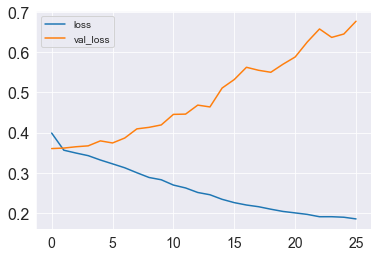

In [1151]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

This is a bad sign - our model is overfitting on our training data. We can try now with some dropout layers.

In [1153]:
model = Sequential()

model.add(Dense(units=68,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=34,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=17,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=7,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [1154]:
model.fit(x=scaled_train, 
          y=y_train.values, 
          epochs=600,
          validation_data=(scaled_val, y_val.values), verbose=1,
          callbacks=[early_stop]
          )

Train on 8953 samples, validate on 5099 samples
Epoch 1/600
8953/8953 [==============================] - 58s 6ms/sample - loss: 0.5771 - val_loss: 0.4521
Epoch 2/600
8953/8953 [==============================] - 1s 117us/sample - loss: 0.4999 - val_loss: 0.4257
Epoch 3/600
8953/8953 [==============================] - 1s 117us/sample - loss: 0.4773 - val_loss: 0.4194
Epoch 4/600
8953/8953 [==============================] - 1s 118us/sample - loss: 0.4536 - val_loss: 0.3914
Epoch 5/600
8953/8953 [==============================] - 1s 120us/sample - loss: 0.4320 - val_loss: 0.3749
Epoch 6/600
8953/8953 [==============================] - 1s 138us/sample - loss: 0.4226 - val_loss: 0.3814
Epoch 7/600
8953/8953 [==============================] - 1s 118us/sample - loss: 0.4123 - val_loss: 0.3751
Epoch 8/600
8953/8953 [==============================] - 1s 118us/sample - loss: 0.4084 - val_loss: 0.3732
Epoch 9/600
8953/8953 [==============================] - 1s 118us/sample - loss: 0.4064 - val_los

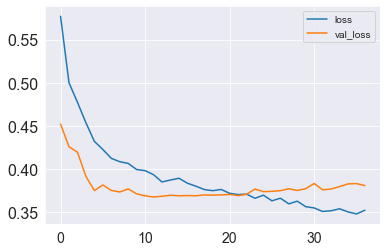

In [1155]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

Unlike our first Neural Network, this one has not overfit to the training data. However, it has made very little improvement in the validation loss, and so we conclude that a model type like this is not suitable for our dataset. 

### Grid Search on Logistic Regression

We find that our logistic regression model had the best results. We can try to tune its parameters also.

In [678]:
# import Logistic Regression model which can be tuned via grid search
from sklearn.linear_model import LogisticRegression

In [1164]:
penalties = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalties)
lr = LogisticRegression()

grid = GridSearchCV(lr, hyperparameters, cv=5, verbose=2)

model = grid.fit(scaled_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ C=1.0, penalty=l2, total=   0.2s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.2s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.2s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.2s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.2s
[CV] C=2.7825594022071245, penalty=l1 ................................
[CV] ................. C=2.7825594022071245, penalty=l1, total=   0.0s
[CV] C=2.7825594022071245, penalty=l1 ................................
[CV] ................. C=2.7825594022071245, penalty=l1, total=   0.0s
[CV] C=2.7825594022071245, penalty=l1 ................................
[CV] .

[CV] ................. C=464.15888336127773, penalty=l2, total=   0.2s
[CV] C=464.15888336127773, penalty=l2 ................................
[CV] ................. C=464.15888336127773, penalty=l2, total=   0.2s
[CV] C=464.15888336127773, penalty=l2 ................................
[CV] ................. C=464.15888336127773, penalty=l2, total=   0.3s
[CV] C=464.15888336127773, penalty=l2 ................................
[CV] ................. C=464.15888336127773, penalty=l2, total=   0.2s
[CV] C=464.15888336127773, penalty=l2 ................................
[CV] ................. C=464.15888336127773, penalty=l2, total=   0.3s
[CV] C=1291.5496650148827, penalty=l1 ................................
[CV] ................. C=1291.5496650148827, penalty=l1, total=   0.0s
[CV] C=1291.5496650148827, penalty=l1 ................................
[CV] ................. C=1291.5496650148827, penalty=l1, total=   0.0s
[CV] C=1291.5496650148827, penalty=l1 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.7s finished


In [1165]:
model.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [1166]:
lr_best = LogisticRegression(penalty='l2',C=1)
lr_best.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [1167]:
best_preds = lr_best.predict(X_val)

print(accuracy_score(best_preds, y_val))
print('\n')
print(confusion_matrix(best_preds, y_val))

0.851931751323789


[[3928  467]
 [ 288  416]]


We don't make huge improvements here. In practice, we would likely use a logistic regression model as one tool of many, including talking to HR colleagues and interviewers themselves who have met with or worked with candidates and employees, in order to maximise our accuracy in terms of new hires.

### Conclusion and Next Steps

We have performed a lot of exploratory analysis on our dataset, and found some interesting insights. We have also used models which could help us in predicting which candidates and employees might be more or less likely to seek a new job. We could use these models as an aid or a guide in determining hiring practices, as well as training schemes or incentives for current workers. All of this could be done with the aim to reduce hiring overhead costs, as well as to improve employee satisfaction and performance.

The next steps would be to talk to HR colleagues in other areas, to find what they think some of the important factors are in employee retention. We could also gather more data, if possible less imbalanced data with fewer missing observations, and to work on this project continuously over several months, in order to improve prediction and to test our models and insights on real-world situations.